# Modeling

0. Planning
1. Data Acquisition
2. Data Preparation
3. Data Exploration
4. **Data Modeling** <- You are here

In this notebook we'll make predictions for the next two weeks of data in December.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 8) # default figure size
import seaborn as sns

import math
import itertools as it

from fbprophet import Prophet
from sklearn import metrics
from sklearn.metrics import mean_squared_error as mse

from acquire import get_fitbit_data
from prepare import prep_fitbit_data

_, activity = prep_fitbit_data(get_fitbit_data())

activity.set_index('date', inplace=True)
activity = activity[activity.steps >= 1000]
activity = activity.resample('D').mean().ffill()

[2019-04-24 12:06:13.442623 acquire.py] Reading data from local csvs
[2019-04-24 12:06:13.449106 prepare.py] Prepping food data frame
[2019-04-24 12:06:13.451782 prepare.py] Prepping activity data frame


We'll be trying to forecast all of the items below:

In [2]:
targets = [
    'calories_burned',
    'distance',
    
    'steps',
    'floors',
    'minutes_sedetary',
    'activity_calories',
    'minutes_active'
]

predictions = pd.DataFrame()

Because all the measures are pretty strongly correlated we'll focus on predicting steps to evaluate different model's performances, and then apply the model we choose to all the other fields.

In [3]:
train, test = activity[:'2018-10'].steps, activity['2018-11':].steps

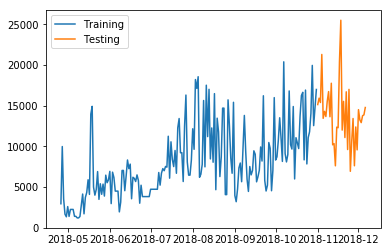

In [4]:
plt.plot(train, label='Training')
plt.plot(test, label='Testing')
plt.legend()

We'll use the mean as our aggregation, as the months / weeks at the beginning and end of the dataset are not complete. 

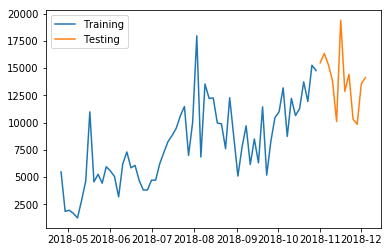

In [5]:
plt.plot(train.resample('3D').mean(), label='Training')
plt.plot(test.resample('3D').mean(), label='Testing')
plt.legend()

We'll define a couple of helper functions to let us quickly compare model performance:

- `evaluate` will calculate mean squared error and root mean squared error for us
- `plot_and_eval` will plot our predictions against the actual values and annotate the plot with the MSE and RMSE

In [6]:
def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=2):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(12, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')

We'll also create a dataframe to hold all of our predictions so that we can compare them as we go.

In [7]:
yhat = pd.DataFrame(dict(actual=test))

### Simple Average Forecast

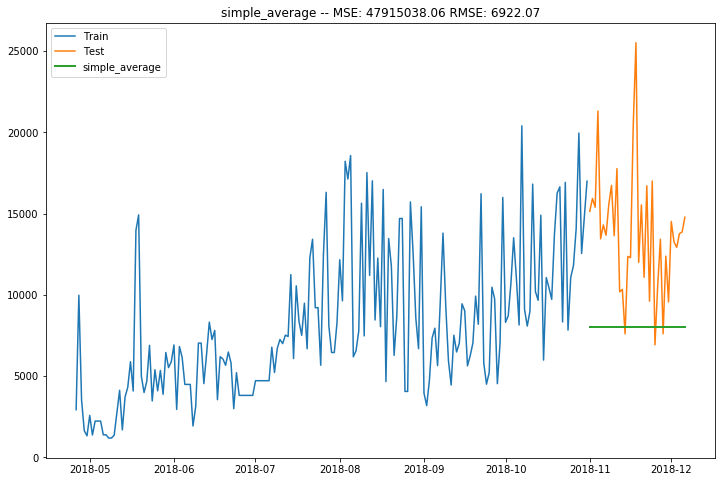

In [8]:
yhat['simple_average'] = train.mean()
plot_and_eval(yhat.simple_average)

This looks pretty terrible.

### Moving Average

Now we will try a moving average forecast, and we'll test out several different values for the number of periods that make up the moving average.

,model,RMSE
0,moving_avg_1,4933.75
1,moving_avg_7,3821.52
2,moving_avg_14,3769.84
3,moving_avg_30,4062.59


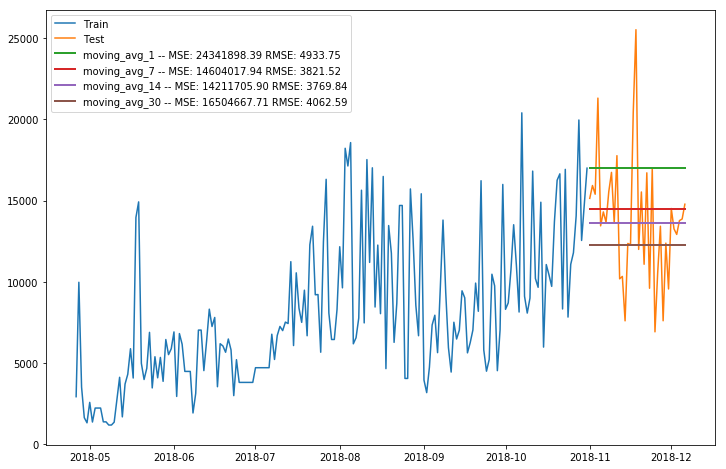

In [9]:
for p in [1, 7, 14, 30]:
    prediction = train.rolling(p).mean().iloc[-1]
    yhat[f'moving_avg_{p}'] = prediction
    
forecasts = [yhat[col] for col in yhat if col.startswith('moving_avg')]

plot_and_eval(forecasts)

yhat[[col for col in yhat if col.startswith('moving_avg')]]\
    .apply(lambda p: rmse(yhat.actual, p))\
    .map('{:.2f}'.format)\
    .reset_index()\
    .set_axis(['model', 'RMSE'], axis=1, inplace=False)

### Holt

In [10]:
from statsmodels.tsa.api import Holt

smoothing_levels = [.1, .3, .5, .7, .9]
smoothing_slopes = [.1, .3, .5, .7, .9]

params = it.product(smoothing_levels, smoothing_slopes)

for level, slope in params:
    title = 'Holt: level = {}, slope = {}'.format(level, slope)
    model = Holt(train).fit(smoothing_level=level, smoothing_slope=slope)
    yhat[title] = model.forecast(test.shape[0])

holt_predictions = yhat[[col for col in yhat if col.startswith('Holt')]]    

# top 5 predictions
top5 = holt_predictions\
    .apply(lambda p: rmse(yhat.actual, p))\
    .map('{:.2f}'.format)\
    .reset_index()\
    .set_axis(['model', 'RMSE'], axis=1, inplace=False)\
    .assign(RMSE=lambda df: df.RMSE.astype(float))\
    .sort_values(by='RMSE').iloc[:5]
top5

,model,RMSE
14,"Holt: level = 0.5, slope = 0.9",3918.72
0,"Holt: level = 0.1, slope = 0.1",6814.67
1,"Holt: level = 0.1, slope = 0.3",8838.48
5,"Holt: level = 0.3, slope = 0.1",8869.10
10,"Holt: level = 0.5, slope = 0.1",10127.04


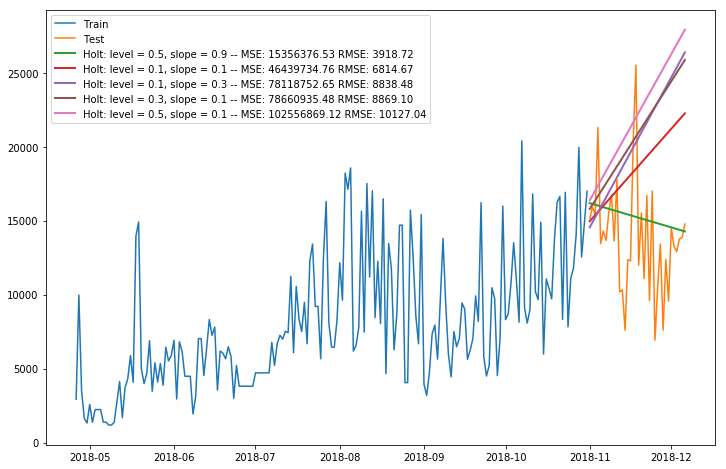

In [11]:
predictions = [yhat[col] for col in top5.model]

plot_and_eval(predictions)

### Prophet

In [12]:
# get the data into a format that prophet wants
test = test.reset_index().rename(columns={'date': 'ds', 'steps': 'y'})
train = train.reset_index().rename(columns={'date': 'ds', 'steps': 'y'})

#### Linear Growth

/Users/zach/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


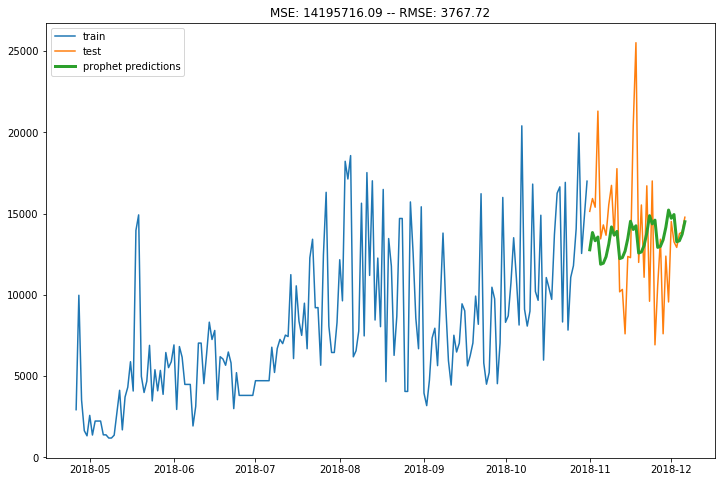

In [16]:
model = Prophet(yearly_seasonality=False, daily_seasonality=False, growth='linear')
model.fit(train)

yhat['prophet_linear'] = model.predict(test).set_index('ds').yhat

plt.figure(figsize=(12, 8))
plt.plot(train.set_index('ds').y, label='train')
plt.plot(yhat.actual, label='test')
plt.plot(yhat.prophet_linear, linewidth=3, label='prophet predictions')

plt.legend()

plt.title('MSE: {:.2f} -- RMSE: {:.2f}'.format(
    mse(yhat.actual, yhat.prophet_linear),
    rmse(yhat.actual, yhat.prophet_linear)
))
None

#### Logistic Growth

For logistic growth, we need to provide a cap and a floor. A floor of 0 makes logical sense, and we'll set our cap at the current max + one standard deviation.

/Users/zach/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


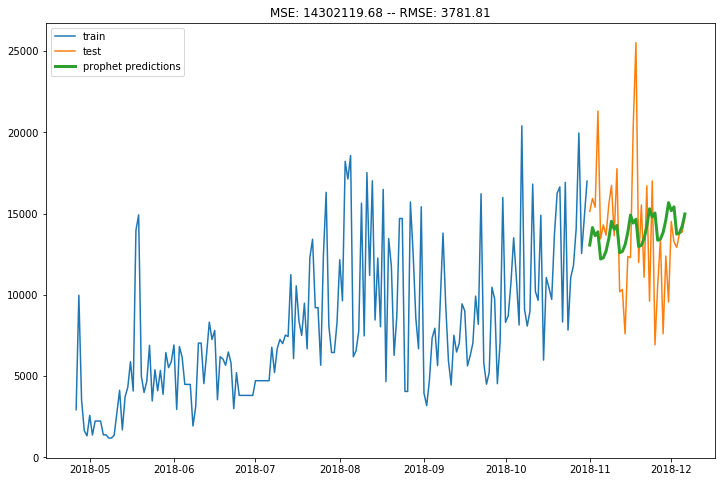

In [14]:
model = Prophet(yearly_seasonality=False, daily_seasonality=False, growth='logistic')

train['cap'] = train.y.max() + train.y.std()
train['floor'] = 0

test['cap'] = train.y.max() + train.y.std()
test['floor'] = 0

model.fit(train)

yhat['prophet_logistic'] = model.predict(test).set_index('ds').yhat

plt.figure(figsize=(12, 8))
plt.plot(train.set_index('ds').y, label='train')
plt.plot(yhat.actual, label='test')
plt.plot(yhat.prophet_logistic, linewidth=3, label='prophet predictions')

plt.legend()

plt.title('MSE: {:.2f} -- RMSE: {:.2f}'.format(
    mse(yhat.actual, yhat.prophet_logistic),
    rmse(yhat.actual, yhat.prophet_logistic)
))
None

## Model Selection

Now let's compare the results of all of the predictions we have made. We'll calculate the mean squared error and the root mean squared error for all of the models. 

In [15]:
(yhat
 .drop(columns='actual')
 .apply(lambda pred: [mse(yhat.actual, pred), rmse(yhat.actual, pred)])
 .apply(pd.Series)
 .set_axis(['MSE', 'RMSE'], axis=1, inplace=False)
 .sort_values(by='MSE'))

,MSE,RMSE
prophet_linear,1.419572e+07,3767.720278
moving_avg_14,1.421171e+07,3769.841628
prophet_logistic,1.430212e+07,3781.814337
moving_avg_7,1.460402e+07,3821.520371
"Holt: level = 0.5, slope = 0.9",1.535638e+07,3918.721288
moving_avg_30,1.650467e+07,4062.593717
moving_avg_1,2.434190e+07,4933.750945
"Holt: level = 0.1, slope = 0.1",4.643973e+07,6814.670554
simple_average,4.791504e+07,6922.068914
"Holt: level = 0.1, slope = 0.3",7.811875e+07,8838.481354


Based on the results above, we'll use the prophet linear model to make all of our predictions.

## Further Improvements

In addition to what we've done here, some other areas to explore might be:

- Better cross validation of models. Currently we have just a single test-train split.
- Tweaking more hyper parameters of the prophet models
- Exploring model performance across multiple features. Currently we just focused on predicting `steps` because all of the measures seem to be highly correlated, but we could also compare model performance across all of the features.
- Other model types, for example, exponential smoothing, or a Holt-Winters model.
- Trying a different sampling period. Currenly we just look at the data on a daily basis. We could "smooth out" the data a little more by resampling the data, for example, every 3 days, or weekly.